In [2]:
import shutil

import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.geometry import Point, box

import whisper
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import wandb
from tqdm import tqdm

import os
import sys

# # Get the current working directory
# current_dir = os.getcwd()

# # Define the project root directory (assuming the notebooks are in a subdirectory)
# project_root = os.path.abspath(os.path.join(current_dir, 'notebooks'))

# # Add the project root directory to the Python path
# sys.path.append(project_root)

from data import BirdClefDataset
from core import WhisperClassifier
from utils import get_device, set_all_seeds, build_run_name

In [3]:
# hard reload core, local module
import importlib
import core
importlib.reload(core)
from core import WhisperClassifier


In [4]:
# hard reload core, local module
import importlib
import utils
importlib.reload(utils)
from utils import get_device, set_all_seeds, build_run_name


In [5]:
import sys
import os
print(os.getcwd())
# print(sys.path)

/root/mlx-whisper/notebooks


In [6]:
wandb.login(key="fce0295fbd7f54f738cd69fbeba699b57c81e93f")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: johnx (machine-learning-institute). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
# # copy training data to subsample/ directory
# shutil.copy("../data/birdclef-2024/train_metadata.csv", "./subsample/original_train_metadata.csv")
# shutil.copy("../data/birdclef-2024/eBird_taxonomy_v2021.csv", "./subsample/eBird_taxonomy_v2021.csv")

In [8]:
training_data = gpd.read_file("./subsample/large/train_metadata_large.csv")

df = training_data.copy()
# drop rows with empty latitude or longitude
df = df[df['latitude'] != '']
df = df[df['longitude'] != '']

# cast to float
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)

In [9]:
df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,geometry
0,eaywag1,[],['flight call'],50.7804,3.3496,Motacilla flava,Western Yellow Wagtail,Eddy Scheinpflug,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/235503,eaywag1/XC235503.ogg,POINT (3.3496 50.7804)
1,eaywag1,[],['flight call'],51.2292,5.2550,Motacilla flava,Western Yellow Wagtail,Toon Jansen,Creative Commons Attribution-NonCommercial-Sha...,3.0,https://www.xeno-canto.org/313823,eaywag1/XC313823.ogg,POINT (5.255 51.2292)
2,eaywag1,[],"['call', 'song']",51.6001,0.7992,Motacilla flava,Western Yellow Wagtail,Craig Brookes,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/316571,eaywag1/XC316571.ogg,POINT (0.7992 51.6001)
3,eaywag1,[],['flight call'],51.0771,-1.7952,Motacilla flava,Western Yellow Wagtail,Simon Gillings,Creative Commons Attribution-NonCommercial-Sha...,1.0,https://www.xeno-canto.org/431856,eaywag1/XC431856.ogg,POINT (-1.7952 51.0771)
4,eaywag1,[],['flight call'],51.9400,5.9038,Motacilla flava,Western Yellow Wagtail,Joost van Bruggen,Creative Commons Attribution-ShareAlike 4.0,5.0,https://www.xeno-canto.org/433384,eaywag1/XC433384.ogg,POINT (5.9038 51.94)


In [10]:
df['geometry'] = df.apply(lambda x: Point(x["longitude"], x["latitude"]), axis=1)
df = gpd.GeoDataFrame(df, geometry="geometry")
df.set_crs(epsg=4326, inplace=True)

df.head()


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,geometry
0,eaywag1,[],['flight call'],50.7804,3.3496,Motacilla flava,Western Yellow Wagtail,Eddy Scheinpflug,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/235503,eaywag1/XC235503.ogg,POINT (3.3496 50.7804)
1,eaywag1,[],['flight call'],51.2292,5.2550,Motacilla flava,Western Yellow Wagtail,Toon Jansen,Creative Commons Attribution-NonCommercial-Sha...,3.0,https://www.xeno-canto.org/313823,eaywag1/XC313823.ogg,POINT (5.255 51.2292)
2,eaywag1,[],"['call', 'song']",51.6001,0.7992,Motacilla flava,Western Yellow Wagtail,Craig Brookes,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/316571,eaywag1/XC316571.ogg,POINT (0.7992 51.6001)
3,eaywag1,[],['flight call'],51.0771,-1.7952,Motacilla flava,Western Yellow Wagtail,Simon Gillings,Creative Commons Attribution-NonCommercial-Sha...,1.0,https://www.xeno-canto.org/431856,eaywag1/XC431856.ogg,POINT (-1.7952 51.0771)
4,eaywag1,[],['flight call'],51.9400,5.9038,Motacilla flava,Western Yellow Wagtail,Joost van Bruggen,Creative Commons Attribution-ShareAlike 4.0,5.0,https://www.xeno-canto.org/433384,eaywag1/XC433384.ogg,POINT (5.9038 51.94)


In [11]:
gb_bbox = box(-19.34,49.06,6.074,62.08)


In [12]:
gb_training_data = df[df.geometry.within(gb_bbox)]

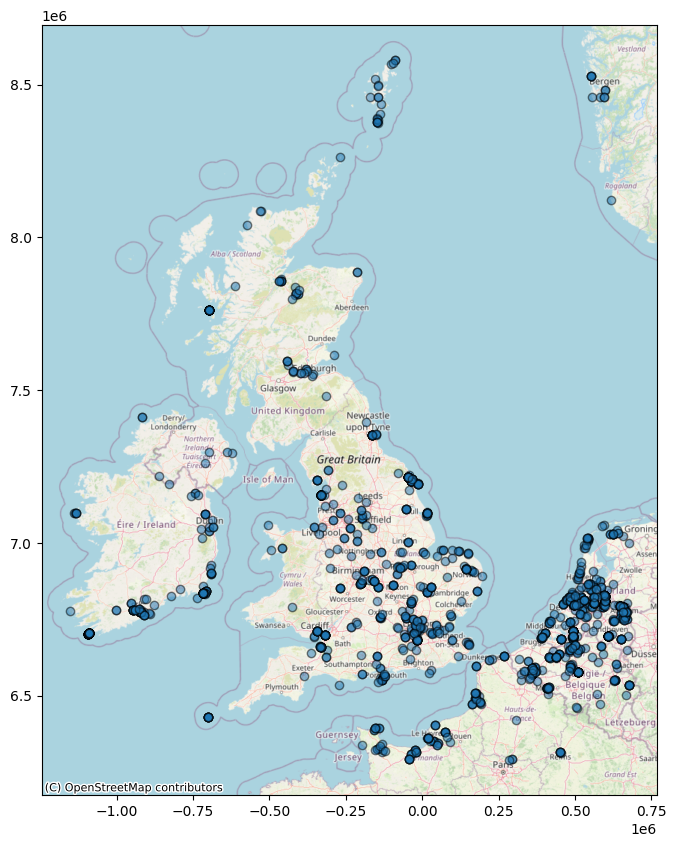

In [13]:
# visualize with basemap
ax = gb_training_data.to_crs(epsg=3857).plot(figsize=(10,10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()



## Example 2 : A small sample of audio files

10 species, ~100 examples each
- classify with our classifier
- train a new classifier on the new data
- test on unseen clips from the same species

## Data Prep

In [14]:
df_cls = df.groupby('primary_label').size().sort_values(ascending=False)[0:10]
classes = sorted(df_cls.index.to_list())
cls2idx_sample = {cls: i for i, cls in enumerate(classes)}

In [15]:
df_classes = pd.read_csv("./subsample/eBird_taxonomy_v2021.csv")

In [16]:
df_sample_classes = df_classes[df_classes['SPECIES_CODE'].isin(classes)].reset_index(drop=True)

In [17]:
df_sample_classes

,TAXON_ORDER,CATEGORY,SPECIES_CODE,PRIMARY_COM_NAME,SCI_NAME,ORDER1,FAMILY,SPECIES_GROUP,REPORT_AS
0,1758,species,litgre1,Little Grebe,Tachybaptus ruficollis,Podicipediformes,Podicipedidae (Grebes),NaN,NaN
1,1997,species,eucdov,Eurasian Collared-Dove,Streptopelia decaocto,Columbiformes,Columbidae (Pigeons and Doves),NaN,NaN
2,5321,species,commoo3,Eurasian Moorhen,Gallinula chloropus,Gruiformes,"Rallidae (Rails, Gallinules, and Coots)",NaN,NaN
3,5346,species,eurcoo,Eurasian Coot,Fulica atra,Gruiformes,"Rallidae (Rails, Gallinules, and Coots)",NaN,NaN
4,5775,species,lirplo,Little Ringed Plover,Charadrius dubius,Charadriiformes,Charadriidae (Plovers and Lapwings),NaN,NaN
5,6025,species,comsan,Common Sandpiper,Actitis hypoleucos,Charadriiformes,Scolopacidae (Sandpipers and Allies),NaN,NaN
6,6028,species,grnsan,Green Sandpiper,Tringa ochropus,Charadriiformes,Scolopacidae (Sandpipers and Allies),NaN,NaN
7,6037,species,comgre,Common Greenshank,Tringa nebularia,Charadriiformes,Scolopacidae (Sandpipers and Allies),NaN,NaN
8,7176,species,graher1,Gray Heron,Ardea cinerea,Pelecaniformes,"Ardeidae (Herons, Egrets, and Bitterns)",NaN,NaN
9,11807,species,rorpar,Rose-ringed Parakeet,Psittacula krameri,Psittaciformes,Psittaculidae (Old World Parrots),NaN,NaN


In [18]:
df_train = df[df['primary_label'].isin(classes)]
df_train = df_train.reset_index(drop=True)

In [19]:
## If we need to regenerate the sample data, we can do so here:
# np.random.seed(42) # note that the data below was not generated with this seed
# df_train = pd.DataFrame()
# df_test = pd.DataFrame()
# for cls in cls_train:
#     df_cls = gb_training_data[gb_training_data['primary_label'] == cls].sample(n=80)
#     df_train = pd.concat([df_train, df_cls[0:75]])
#     df_test = pd.concat([df_test, df_cls[75:]])
# df_train.to_csv("./subsample/train_metadata_10sp-80ex.csv", index=False)
# df_test.to_csv("./subsample/test_metadata_10sp-80ex.csv", index=False)


# df_train = pd.read_csv("./subsample/large/train_metadata_large.csv")
# df_test = pd.read_csv("./subsample/test_metadata.csv")
# print("df_sample_classes are the same as in df_train:", 
#     sorted(list(df_train['primary_label'].unique())) == sorted(classes))
# df_train.head()

## Classification
We have now hijacked the Whisper encoder to produce an encoded representation of the audio clip. 

There are a few ways to do this — I'm curious to see how they compare.

In [20]:
# # hard reload core, local module
# import importlib
# import core
# importlib.reload(core)
# from core import WhisperClassifierMeanPool, WhisperClassifierMeanPoolFF, WhisperClassifierMaxPoolFF

In [37]:
# Hyperparameters
EPOCHS_3 = 3
BATCH_SIZE_8 = 8
LEARNING_RATE_001 = 0.001
WHISPER_MODEL_SMALL = "small"
NUM_CLASSES_10 = len(df_sample_classes)
RANDOM_SEED = 42
PROJECTION_DIM_FACTOR = 2
FEEDFORWARD = True
POOLING = "mean"
DATASET_NAME = "10sp-approx100ex"

DEVICE = get_device()

hyperparameters = {
    "EPOCHS": EPOCHS_3,
    "BATCH_SIZE": BATCH_SIZE_8,
    "LEARNING_RATE": LEARNING_RATE_001,
    "WHISPER_MODEL": WHISPER_MODEL_SMALL,
    "NUM_CLASSES": NUM_CLASSES_10,
    "RANDOM_SEED": RANDOM_SEED,
    "PROJECTION_DIM_FACTOR": PROJECTION_DIM_FACTOR,
    "DATASET_NAME": DATASET_NAME,
    "FEEDFORWARD": FEEDFORWARD,
    "POOLING": POOLING,
    "DEVICE": DEVICE,
}


In [22]:

def train_model(model, 
                optimizer, 
                criterion, 
                dataloader, 
                epochs, 
                model_name, 
                seed=42,
                save_model=True,
                hyperparameters=hyperparameters):
    run_name = build_run_name(hyperparameters, model_name)
    set_all_seeds(seed)

    device = get_device()
    model = model.to(device)
    model.train()

    for epoch in tqdm(range(epochs), desc=f"Training {model_name}"):
        epoch_loss = 0.0

        for batch_idx, batch in tqdm(
            enumerate(dataloader), 
            desc="Training", 
            total=len(dataloader)):
        
            optimizer.zero_grad()
            mel_spectrograms, target_classes, _ = batch
            mel_spectrograms = mel_spectrograms.to(model.device)
            target_classes = target_classes.to(model.device)

            logits = model(mel_spectrograms)
            loss = criterion(logits, target_classes)

            loss.backward()
            optimizer.step()

            wandb.log({
                f"batch_loss": loss.item()
            })
        
        wandb.log({
            f"epoch_loss": epoch_loss / len(dataloader)
        })
        # Save model
        if save_model:
            torch.save(model.state_dict(), f"./subsample/models/{run_name}.pth")
            


In [23]:
# hard reload birdclefdataset, local module

# import importlib
# import data
# importlib.reload(data)
# from data import BirdClefDataset

In [24]:
df_train 

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,geometry
0,lirplo,[],"['call', 'female']",49.9149,-6.3029,Charadrius dubius,Little Ringed Plover,Ashley Fisher,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/128884,lirplo/XC128884.ogg,POINT (-6.3029 49.9149)
1,lirplo,[],['call'],51.0383,3.9184,Charadrius dubius,Little Ringed Plover,Erik Roels,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/142810,lirplo/XC142810.ogg,POINT (3.9184 51.0383)
2,lirplo,[],['call'],51.7159,5.6055,Charadrius dubius,Little Ringed Plover,Bart Gras,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/234556,lirplo/XC234556.ogg,POINT (5.6055 51.7159)
3,lirplo,[],['flight call'],51.9400,5.9038,Charadrius dubius,Little Ringed Plover,Joost van Bruggen,Creative Commons Attribution-NonCommercial-Sha...,2.0,https://www.xeno-canto.org/287734,lirplo/XC287734.ogg,POINT (5.9038 51.94)
4,lirplo,[],['call'],51.4834,0.2942,Charadrius dubius,Little Ringed Plover,David Darrell-Lambert,Creative Commons Attribution-NonCommercial-Sha...,3.0,https://www.xeno-canto.org/380178,lirplo/XC380178.ogg,POINT (0.2942 51.4834)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,rorpar,[],[''],51.2600,4.4941,Psittacula krameri,Rose-ringed Parakeet,Wim Jacobs,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://xeno-canto.org/856220,rorpar/XC856220.ogg,POINT (4.4941 51.26)
984,rorpar,[],[''],51.2600,4.4941,Psittacula krameri,Rose-ringed Parakeet,Wim Jacobs,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://xeno-canto.org/856222,rorpar/XC856222.ogg,POINT (4.4941 51.26)
985,rorpar,[],[''],51.1936,4.3906,Psittacula krameri,Rose-ringed Parakeet,Wim Jacobs,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://xeno-canto.org/856224,rorpar/XC856224.ogg,POINT (4.3906 51.1936)
986,rorpar,[],[''],52.5331,-1.9501,Psittacula krameri,Rose-ringed Parakeet,Paul Bate,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://xeno-canto.org/856357,rorpar/XC856357.ogg,POINT (-1.9501 52.5331)


In [25]:
dataset_train = BirdClefDataset(df_train, "./large", df_sample_classes, 'large')
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE_8, shuffle=True, num_workers=4)
    # TODO: Optimize batch_size for GPU

In [26]:
# make sure the dataset / dataloader are working
next(iter(dataloader_train))

[tensor([[[-0.9312, -0.9312, -0.9312,  ...,  0.0000,  0.0000,  0.0000],
          [-0.9312, -0.9312, -0.9312,  ...,  0.0000,  0.0000,  0.0000],
          [-0.9312, -0.9312, -0.9312,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [-0.9312, -0.9312, -0.9312,  ...,  0.0000,  0.0000,  0.0000],
          [-0.9312, -0.9312, -0.9312,  ...,  0.0000,  0.0000,  0.0000],
          [-0.9312, -0.9312, -0.9312,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[-1.0000, -0.9338, -0.6588,  ..., -0.3788, -0.6478, -0.4676],
          [-1.0000, -0.8896, -0.8215,  ..., -0.0574, -0.1731, -0.2227],
          [-1.0000, -1.0000, -1.0000,  ...,  0.0037, -0.0021, -0.1138],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -0.2000, -0.3366, -0.1977],
          [-1.0000, -1.0000, -1.0000,  ..., -0.2931, -0.2522, -0.2918],
          [-1.0000, -1.0000, -1.0000,  ..., -0.3634, -0.2962, -0.2735]],
 
         [[-1.0000, -1.0000, -1.0000,  ...,  0.0000,  0.0000,  0.0000],
          [-1.0000, -1.0000,

In [27]:
# Clear memory
torch.cuda.empty_cache()


In [33]:
models = {
    # "mean_pool": {
    #     "model": WhisperClassifier(WHISPER_MODEL_SMALL, 
    #                                NUM_CLASSES_10, 
    #                                PROJECTION_DIM_FACTOR, 
    #                                feedforward=False, 
    #                                pooling="mean"),
    #     "criterion": torch.nn.CrossEntropyLoss(),
    # },
    "mean_pool_ff": {
        "model": WhisperClassifier(WHISPER_MODEL_SMALL, 
                                   NUM_CLASSES_10, 
                                   PROJECTION_DIM_FACTOR, 
                                   feedforward=True, 
                                   pooling="mean"),
        "criterion": torch.nn.CrossEntropyLoss(),
    },
    "max_pool_ff": {
        "model": WhisperClassifier(WHISPER_MODEL_SMALL, 
                                   NUM_CLASSES_10, 
                                   PROJECTION_DIM_FACTOR, 
                                   feedforward=True, 
                                   pooling="max"),
        "criterion": torch.nn.CrossEntropyLoss(),
    }
}


/root/.cache/pypoetry/virtualenvs/mlx-whisper-Mr4HmBsl-py3.9/lib/python3.9/site-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = 

In [34]:
# models["mean_pool"]["optimizer"] = torch.optim.Adam(models["mean_pool"]["model"].parameters(), lr=LEARNING_RATE_001)
models["mean_pool_ff"]["optimizer"] = torch.optim.Adam(models["mean_pool_ff"]["model"].parameters(), lr=LEARNING_RATE_001)
models["max_pool_ff"]["optimizer"] = torch.optim.Adam(models["max_pool_ff"]["model"].parameters(), lr=LEARNING_RATE_001)

In [35]:
print("Logging to wandb")

Logging to wandb


In [38]:
for model_name, model_info in models.items():
    run_name = build_run_name(hyperparameters, model_name)
    wandb.init(project="mlx-whisper-gpu", name=run_name)
    print(f"Training {model_name}")
    train_model(model=model_info["model"], 
                optimizer=model_info["optimizer"], 
                criterion=model_info["criterion"], 
                dataloader=dataloader_train, 
                epochs=EPOCHS_3, 
                model_name=model_name, 
                seed=RANDOM_SEED,
                save_model=False)

wandb.finish()


Training mean_pool_ff


Training mean_pool_ff: 100%|██████████| 3/3 [03:58<00:00, 79.66s/it]


batch_loss,▁▄█▂▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_loss,▁▁▁
batch_loss,2.30701
epoch_loss,0


Training max_pool_ff


Training max_pool_ff: 100%|██████████| 3/3 [03:57<00:00, 79.25s/it]


batch_loss,▅▁█▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
epoch_loss,▁▁▁
batch_loss,2.31627
epoch_loss,0


In [43]:
models["mean_pool"]["model"].encoder.positional_embedding.shape

torch.Size([1500, 768])

In [101]:
dataset_test = BirdClefDataset(df_test, "./subsample", df_sample_classes, "test")
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

In [103]:
model = models["mean_pool"]["model"]
criterion = models["mean_pool"]["criterion"]
classifier = model
model.eval()
for batch_idx, (mel_input, cls_actual, _) in tqdm(enumerate(dataloader_test), desc="Testing", total=len(dataloader_test)):
    mel_input = mel_input.to(model.device)
    cls_actual = cls_actual.to(model.device)

    logits = classifier(mel_input)
    loss = criterion(logits, cls_actual)
    predicted_idx = torch.argmax(logits, dim=1).item()
    actual_idx = torch.argmax(cls_actual, dim=1).item()
    predicted = df_sample_classes.iloc[predicted_idx]
    actual = df_sample_classes.iloc[actual_idx]
    print(f"""
====================
          Predicted: {predicted['SPECIES_CODE']} ({predicted['PRIMARY_COM_NAME']})
          Actual: {actual['SPECIES_CODE']} ({actual['PRIMARY_COM_NAME']})
          Loss: {loss.item()}
""")


Testing:   2%|▏         | 1/50 [00:01<01:08,  1.39s/it]


          Predicted: comsan (Common Sandpiper)
          Actual: eurcoo (Eurasian Coot)
          Loss: 2.520446300506592



Testing:   4%|▍         | 2/50 [00:02<00:49,  1.03s/it]


          Predicted: lirplo (Little Ringed Plover)
          Actual: eurcoo (Eurasian Coot)
          Loss: 3.913379430770874



Testing:   6%|▌         | 3/50 [00:02<00:34,  1.35it/s]


          Predicted: lirplo (Little Ringed Plover)
          Actual: eurcoo (Eurasian Coot)
          Loss: 2.042778730392456



Testing:   8%|▊         | 4/50 [00:03<00:33,  1.38it/s]


          Predicted: eucdov (Eurasian Collared-Dove)
          Actual: eurcoo (Eurasian Coot)
          Loss: 2.4775948524475098



Testing:  10%|█         | 5/50 [00:04<00:38,  1.16it/s]


          Predicted: lirplo (Little Ringed Plover)
          Actual: eurcoo (Eurasian Coot)
          Loss: 2.218153476715088



Testing:  12%|█▏        | 6/50 [00:04<00:32,  1.35it/s]


          Predicted: lirplo (Little Ringed Plover)
          Actual: commoo3 (Eurasian Moorhen)
          Loss: 1.8027122020721436



Testing:  14%|█▍        | 7/50 [00:05<00:28,  1.52it/s]


          Predicted: lirplo (Little Ringed Plover)
          Actual: commoo3 (Eurasian Moorhen)
          Loss: 1.9291129112243652



Testing:  16%|█▌        | 8/50 [00:05<00:24,  1.73it/s]


          Predicted: eucdov (Eurasian Collared-Dove)
          Actual: commoo3 (Eurasian Moorhen)
          Loss: 2.338344097137451



Testing:  18%|█▊        | 9/50 [00:06<00:22,  1.82it/s]


          Predicted: lirplo (Little Ringed Plover)
          Actual: commoo3 (Eurasian Moorhen)
          Loss: 2.031494617462158



Testing:  20%|██        | 10/50 [00:07<00:25,  1.60it/s]


          Predicted: lirplo (Little Ringed Plover)
          Actual: commoo3 (Eurasian Moorhen)
          Loss: 2.0331039428710938



Testing:  22%|██▏       | 11/50 [00:07<00:21,  1.79it/s]


          Predicted: eurcoo (Eurasian Coot)
          Actual: litgre1 (Little Grebe)
          Loss: 2.277482509613037



Testing:  24%|██▍       | 12/50 [00:07<00:19,  1.96it/s]


          Predicted: comsan (Common Sandpiper)
          Actual: litgre1 (Little Grebe)
          Loss: 2.4231369495391846



Testing:  26%|██▌       | 13/50 [00:08<00:17,  2.09it/s]


          Predicted: lirplo (Little Ringed Plover)
          Actual: litgre1 (Little Grebe)
          Loss: 2.324272632598877



Testing:  28%|██▊       | 14/50 [00:08<00:18,  1.95it/s]


          Predicted: lirplo (Little Ringed Plover)
          Actual: litgre1 (Little Grebe)
          Loss: 2.3522942066192627



Testing:  30%|███       | 15/50 [00:09<00:17,  1.95it/s]


          Predicted: lirplo (Little Ringed Plover)
          Actual: litgre1 (Little Grebe)
          Loss: 2.338491678237915



Testing:  32%|███▏      | 16/50 [00:10<00:19,  1.77it/s]


          Predicted: lirplo (Little Ringed Plover)
          Actual: comsan (Common Sandpiper)
          Loss: 1.9287817478179932



Testing:  34%|███▍      | 17/50 [00:10<00:19,  1.74it/s]


          Predicted: lirplo (Little Ringed Plover)
          Actual: comsan (Common Sandpiper)
          Loss: 1.8911731243133545



Testing:  36%|███▌      | 18/50 [00:11<00:18,  1.71it/s]


          Predicted: lirplo (Little Ringed Plover)
          Actual: comsan (Common Sandpiper)
          Loss: 1.872498869895935



Testing:  38%|███▊      | 19/50 [00:11<00:17,  1.79it/s]


          Predicted: lirplo (Little Ringed Plover)
          Actual: comsan (Common Sandpiper)
          Loss: 1.929192304611206



Testing:  40%|████      | 20/50 [00:12<00:17,  1.75it/s]


          Predicted: lirplo (Little Ringed Plover)
          Actual: comsan (Common Sandpiper)
          Loss: 2.140288829803467



Testing:  42%|████▏     | 21/50 [00:12<00:16,  1.72it/s]


          Predicted: lirplo (Little Ringed Plover)
          Actual: graher1 (Gray Heron)
          Loss: 7.166418075561523



Testing:  44%|████▍     | 22/50 [00:13<00:15,  1.80it/s]


          Predicted: eurcoo (Eurasian Coot)
          Actual: graher1 (Gray Heron)
          Loss: 3.026634693145752



Testing:  46%|████▌     | 23/50 [00:14<00:15,  1.75it/s]


          Predicted: eurcoo (Eurasian Coot)
          Actual: graher1 (Gray Heron)
          Loss: 3.0859622955322266



Testing:  48%|████▊     | 24/50 [00:14<00:14,  1.82it/s]


          Predicted: eurcoo (Eurasian Coot)
          Actual: graher1 (Gray Heron)
          Loss: 3.250007152557373



Testing:  50%|█████     | 25/50 [00:15<00:13,  1.87it/s]


          Predicted: lirplo (Little Ringed Plover)
          Actual: graher1 (Gray Heron)
          Loss: 5.800881385803223



Testing:  52%|█████▏    | 26/50 [00:15<00:13,  1.81it/s]


          Predicted: lirplo (Little Ringed Plover)
          Actual: comgre (Common Greenshank)
          Loss: 2.4402222633361816



Testing:  54%|█████▍    | 27/50 [00:16<00:11,  1.97it/s]


          Predicted: eurcoo (Eurasian Coot)
          Actual: comgre (Common Greenshank)
          Loss: 2.427726984024048



Testing:  56%|█████▌    | 28/50 [00:16<00:11,  1.98it/s]


          Predicted: eurcoo (Eurasian Coot)
          Actual: comgre (Common Greenshank)
          Loss: 2.5157885551452637



Testing:  58%|█████▊    | 29/50 [00:16<00:09,  2.11it/s]


          Predicted: eurcoo (Eurasian Coot)
          Actual: comgre (Common Greenshank)
          Loss: 2.5135140419006348



Testing:  60%|██████    | 30/50 [00:17<00:09,  2.08it/s]


          Predicted: lirplo (Little Ringed Plover)
          Actual: comgre (Common Greenshank)
          Loss: 2.6950783729553223



Testing:  62%|██████▏   | 31/50 [00:17<00:09,  2.06it/s]


          Predicted: lirplo (Little Ringed Plover)
          Actual: lirplo (Little Ringed Plover)
          Loss: 1.047102928161621



Testing:  64%|██████▍   | 32/50 [00:18<00:09,  1.92it/s]


          Predicted: eurcoo (Eurasian Coot)
          Actual: lirplo (Little Ringed Plover)
          Loss: 2.432591676712036



Testing:  66%|██████▌   | 33/50 [00:19<00:09,  1.83it/s]


          Predicted: lirplo (Little Ringed Plover)
          Actual: lirplo (Little Ringed Plover)
          Loss: 0.696956992149353



Testing:  68%|██████▊   | 34/50 [00:19<00:08,  1.79it/s]


          Predicted: lirplo (Little Ringed Plover)
          Actual: lirplo (Little Ringed Plover)
          Loss: 1.2275710105895996



Testing:  70%|███████   | 35/50 [00:20<00:08,  1.83it/s]


          Predicted: eurcoo (Eurasian Coot)
          Actual: lirplo (Little Ringed Plover)
          Loss: 2.5087175369262695



Testing:  72%|███████▏  | 36/50 [00:20<00:08,  1.70it/s]


          Predicted: lirplo (Little Ringed Plover)
          Actual: rorpar (Rose-ringed Parakeet)
          Loss: 3.441009521484375



Testing:  74%|███████▍  | 37/50 [00:21<00:08,  1.53it/s]


          Predicted: comsan (Common Sandpiper)
          Actual: rorpar (Rose-ringed Parakeet)
          Loss: 3.8203482627868652



Testing:  76%|███████▌  | 38/50 [00:22<00:08,  1.44it/s]


          Predicted: commoo3 (Eurasian Moorhen)
          Actual: rorpar (Rose-ringed Parakeet)
          Loss: 2.040131092071533



Testing:  78%|███████▊  | 39/50 [00:23<00:07,  1.50it/s]


          Predicted: eurcoo (Eurasian Coot)
          Actual: rorpar (Rose-ringed Parakeet)
          Loss: 2.5545477867126465



Testing:  80%|████████  | 40/50 [00:23<00:06,  1.62it/s]


          Predicted: comsan (Common Sandpiper)
          Actual: rorpar (Rose-ringed Parakeet)
          Loss: 4.524017810821533



Testing:  82%|████████▏ | 41/50 [00:25<00:09,  1.06s/it]


          Predicted: lirplo (Little Ringed Plover)
          Actual: grnsan (Green Sandpiper)
          Loss: 2.5130701065063477



Testing:  84%|████████▍ | 42/50 [00:26<00:07,  1.12it/s]


          Predicted: eurcoo (Eurasian Coot)
          Actual: grnsan (Green Sandpiper)
          Loss: 2.278805732727051



Testing:  86%|████████▌ | 43/50 [00:26<00:05,  1.24it/s]


          Predicted: lirplo (Little Ringed Plover)
          Actual: grnsan (Green Sandpiper)
          Loss: 3.5734753608703613



Testing:  88%|████████▊ | 44/50 [00:28<00:06,  1.13s/it]


          Predicted: eurcoo (Eurasian Coot)
          Actual: grnsan (Green Sandpiper)
          Loss: 2.307931423187256



Testing:  90%|█████████ | 45/50 [00:29<00:04,  1.02it/s]


          Predicted: lirplo (Little Ringed Plover)
          Actual: grnsan (Green Sandpiper)
          Loss: 2.73268461227417



Testing:  92%|█████████▏| 46/50 [00:29<00:03,  1.20it/s]


          Predicted: comsan (Common Sandpiper)
          Actual: eucdov (Eurasian Collared-Dove)
          Loss: 1.6580376625061035



Testing:  94%|█████████▍| 47/50 [00:30<00:02,  1.37it/s]


          Predicted: eucdov (Eurasian Collared-Dove)
          Actual: eucdov (Eurasian Collared-Dove)
          Loss: 1.549953818321228



Testing:  96%|█████████▌| 48/50 [00:30<00:01,  1.45it/s]


          Predicted: eucdov (Eurasian Collared-Dove)
          Actual: eucdov (Eurasian Collared-Dove)
          Loss: 1.4775335788726807



Testing:  98%|█████████▊| 49/50 [00:31<00:00,  1.44it/s]


          Predicted: eucdov (Eurasian Collared-Dove)
          Actual: eucdov (Eurasian Collared-Dove)
          Loss: 1.8546684980392456



Testing: 100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


          Predicted: comsan (Common Sandpiper)
          Actual: eucdov (Eurasian Collared-Dove)
          Loss: 1.4626507759094238

